# Installing and importing dependencies

In [1]:
! pip install PyWavelets
! pip install obspy
# Import dependencies
from scipy import *
from scipy.signal import butter, filtfilt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
import torch
import torch.nn as nn
import torch.nn.functional as F

# Mount to drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create STA/LTA function


In [2]:
# parameters:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

def sta_lta(tr, sta_window, lta_window, sampling_rate):
  df = sampling_rate
  cft = classic_sta_lta(tr.data, int(sta_window * df), int(lta_window * df))
  return cft

# Create miniSEED to times,data function


In [3]:
def mini_to_times_data(mini_file):
  data_directory = './drive/MyDrive/data/lunar/training/data/S12_GradeA/'
  mseed_file = f'{data_directory}{mini_file}.mseed'
  print("reading", mseed_file)
  st = read(mseed_file)
  tr = st.traces[0].copy()
  # tr_times = tr.times()
  # tr_data = tr.data
  return tr

# Frequency Filters

In [4]:
# Create function to apply bandpass filter
def band_pass_filter(st, minfreq=0.5, maxfreq=1.0):
  # Going to create a separate trace for the filter data
  st_filt = st.copy()
  st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
  tr_filt = st_filt.traces[0].copy()
  tr_times_filt = tr_filt.times()
  tr_data_filt = tr_filt.data
# Create function to apply high-pass filter
def high_pass_filter(data, cutoff_frequency, sampling_rate, order=16):
  nyquist = 0.5 * sampling_rate
  normal_cutoff = cutoff_frequency / nyquist

  b, a = butter(order, normal_cutoff, btype='high', analog=True)
  filtered_data = filtfilt(b, a, data)
  return filtered_data

def low_pass_filter(data, cutoff_frequency, sampling_rate, order=16):
  nyquist = 0.5 * sampling_rate
  normal_cutoff = cutoff_frequency / nyquist

  b, a = butter(order, normal_cutoff, btype='low', analog=True)
  filtered_data = filtfilt(b, a, data)
  return filtered_data

# Calculate Cutoff Frequency

In [16]:
import scipy

def calculateCutoffFrequency(tr):
  return 2
  peaks = []
  peaks_indices = []
  peaks_indices = scipy.signal.find_peaks(tr)
  for i in range(len(peaks_indices)):
    peaks.append(tr[peaks_indices[0]])

  if len(peaks) == 0 or sum(peaks) == 0:
    return 2;
  return sum(peaks) / len(peaks)

# Lognormal Wavelet Transform

In [17]:

import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal

# Step 1: Normalize both signals
def normalize(signal: np.ndarray) -> np.ndarray:
    """Normalize the signal to the range [0, 1]."""
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

def apply_lognormal_wavelet(seismic_data):
  """This function applies a convolution-based Continuous Wavelet Transform (CWT)
      where we construct our own custom wavelet based on a lognormal function and
      apply this to the seismic signal.
  """
  # Define the custom lognormal wavelet function
  def lognormal_wavelet(t, s):
      # Use a log-normal wavelet function
      # t is the time vector, s is the scale
      # Define mu and sigma for the distribution
      mu = 0
      sigma = 1
      return (1 / (t * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(t) - mu)**2) / (2 * sigma**2))
  # Define the scales to apply for the CWT
  scales = np.arange(100000, 100100)
  # Define the time space to construct the wavelet on
  t_vals = np.linspace(0.1, 10, 1000)
  # Define a wrapper of lognormal_wavelet to pass into signal.cwt
  def custom_wavelet(t, scale):
      """Constructs lognormal wavelet and translates to
      be in line with given seismic data"""
      # Create and translate the wavelet
      return lognormal_wavelet(t_vals, scale) + 0.5

  # Apply Continuous Wavelet Transform using convolution
  coefficients = signal.cwt(seismic_data, custom_wavelet, scales)
  # Reconstruct a signal based on the coefficients of the wavelet transform
  reconstructed_signal = np.mean(np.abs(coefficients), axis=0)
  # Normalize signals
  original_signal_normalized = normalize(seismic_data)
  reconstructed_signal_normalized = normalize(reconstructed_signal)

  # Can choose to exaggerate peaks in reconstructed signal
  exaggeration_factor = 1  # Tune this parameter
  exaggerated_reconstructed_signal = reconstructed_signal_normalized * exaggeration_factor

  # Ensure it doesn't exceed 1 for blending
  exaggerated_reconstructed_signal = np.clip(exaggerated_reconstructed_signal, 0, 1)

  # Blend the original signal with the exaggerated reconstructed signal
  # You can choose a blending factor to determine how much influence the reconstructed signal has
  # blending_factor = 0.1  # Control how much of the reconstructed signal to add to the original
  # Uncomment below to blend together
  # mixed_signal = (1 - blending_factor) * original_signal_normalized + blending_factor * exaggerated_reconstructed_signal
  # mixed_signal = original_signal_normalized * exaggerated_reconstructed_signal

  # Create a boolean mask of what to include from the original signal
  mixed_signal = np.where((reconstructed_signal_normalized < 0.1) & (reconstructed_signal_normalized > 0.01), original_signal_normalized, 0.5)
  # Return the mixed signal with a high pass filter
  return high_pass_filter(mixed_signal, calculateCutoffFrequency(tr), tr.stats.sampling_rate)

# apply_lognormal_wavelet(tr_data)

# Seismic Event Detection Algorithm

reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-01-19HR00_evid00002.mseed


<ipython-input-17-32906284e7cb>:36: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  coefficients = signal.cwt(seismic_data, custom_wavelet, scales)


reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-25HR00_evid00003.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-26HR00_evid00004.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-04-25HR00_evid00006.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-04-26HR00_evid00007.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-06-15HR00_evid00008.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-06-26HR00_evid00009.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-07-20HR00_evid00010.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-07-20HR00_evid00011.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-09-26HR00_evid00013.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_Gr

<ipython-input-18-abcd7bdb6ddc>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,1,figsize=(12,3))


reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-05-12HR00_evid00031.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-05-12HR00_evid00032.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-05-13HR00_evid00033.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-05-23HR00_evid00034.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-06-12HR00_evid00035.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-09-25HR00_evid00042.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-10-18HR00_evid00043.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-10-20HR00_evid00044.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-10-31HR00_evid00045.mseed
reading ./drive/MyDrive/data/lunar/training/data/S12_Gr

[(0, 120464, 0),
 (0, 243174, 0),
 (0, 389635, 0),
 (0, 451086, 0),
 (0, 486877, 0),
 (1, 86299, 0),
 (2, 485138, 0),
 (3, 31343, 0),
 (4, 5618, 0),
 (4, 340795, 0),
 (5, 383059, 0),
 (5, 453398, 0),
 (6, 9252, 0),
 (7, 8852, 0),
 (7, 122108, 0),
 (7, 280187, 0),
 (8, 8852, 0),
 (8, 122108, 0),
 (8, 280187, 0),
 (9, 342330, 0),
 (9, 477545, 0),
 (10, 427778, 0),
 (10, 450134, 0),
 (10, 456688, 0),
 (10, 464423, 0),
 (10, 492492, 0),
 (10, 499902, 0),
 (10, 532581, 0),
 (10, 553695, 0),
 (11, 39455, 0),
 (11, 61321, 0),
 (11, 72414, 0),
 (11, 102589, 0),
 (11, 127199, 0),
 (11, 236158, 0),
 (11, 308471, 0),
 (11, 355843, 0),
 (12, 176589, 0),
 (13, 366586, 0),
 (13, 490723, 0),
 (13, 566072, 0),
 (14, 58092, 1),
 (14, 69489, 0),
 (14, 265738, 0),
 (14, 486224, 0),
 (15, 301601, 0),
 (17, 439568, 0),
 (18, 56190, 0),
 (18, 90251, 0),
 (18, 341821, 0),
 (19, 6779, 0),
 (21, 84416, 0),
 (21, 139967, 0),
 (21, 168684, 0),
 (21, 226969, 0),
 (21, 498696, 0),
 (22, 233278, 0),
 (23, 233278, 0

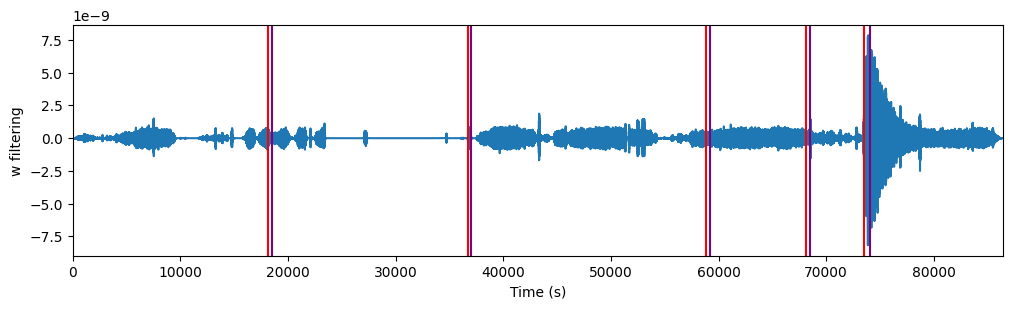

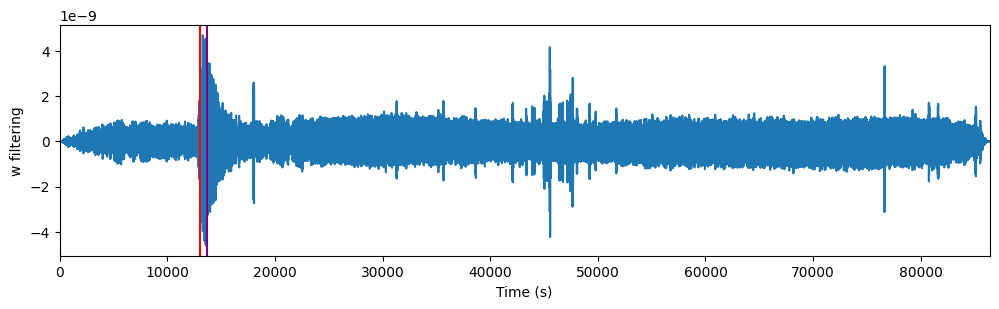

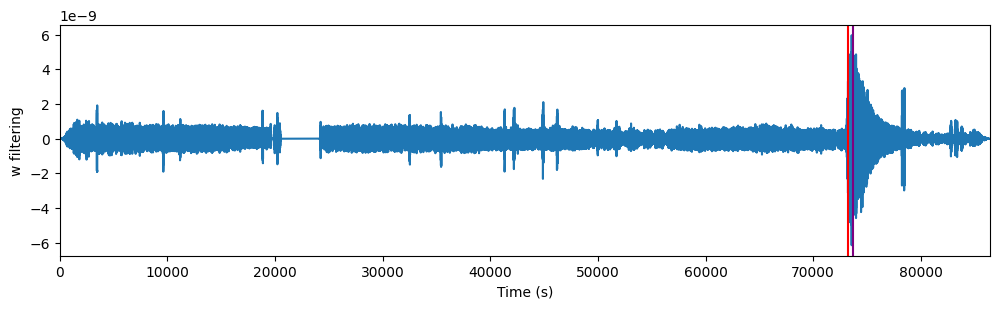

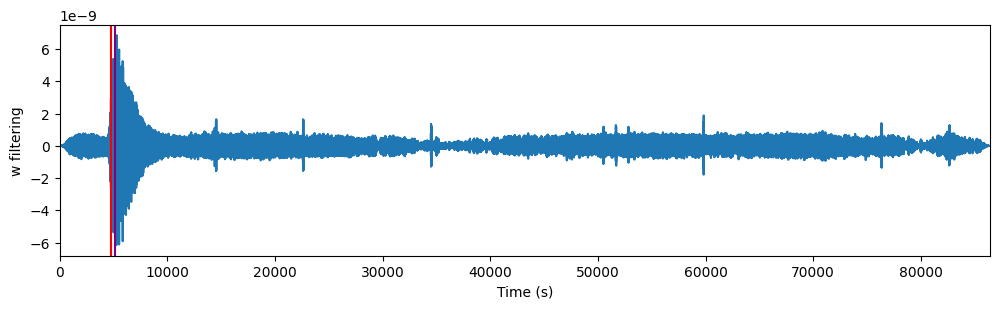

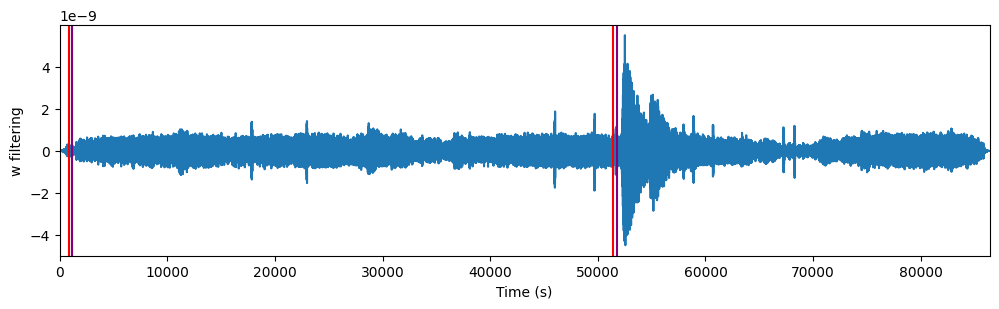

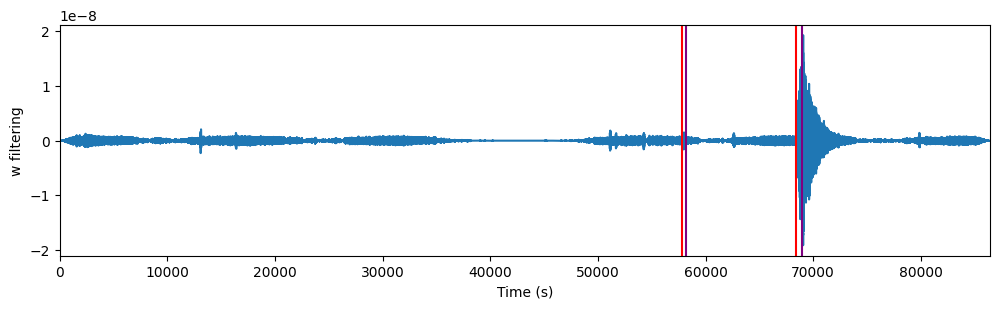

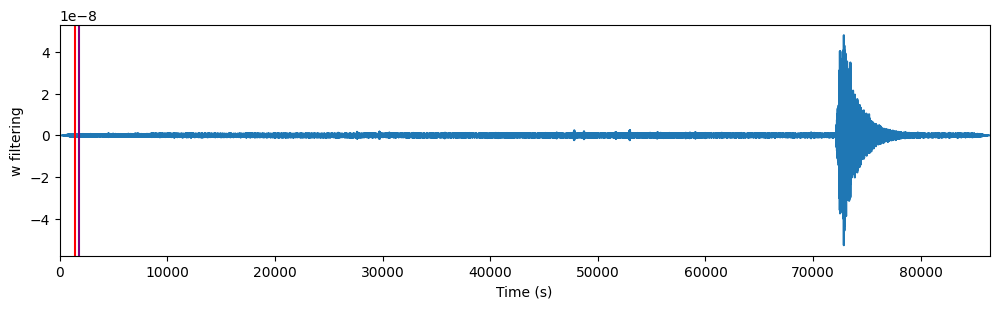

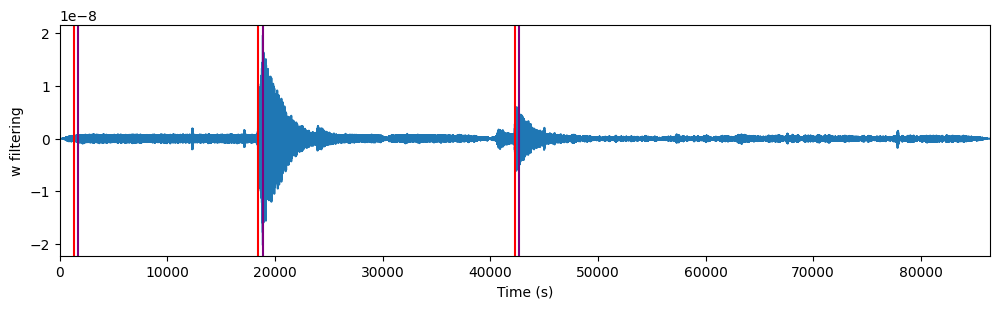

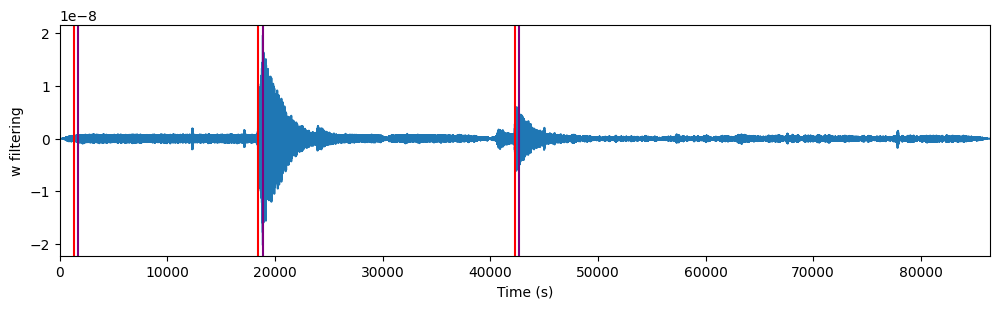

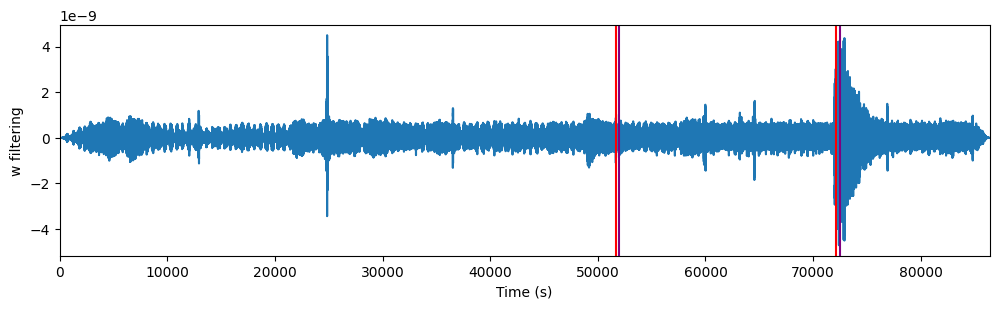

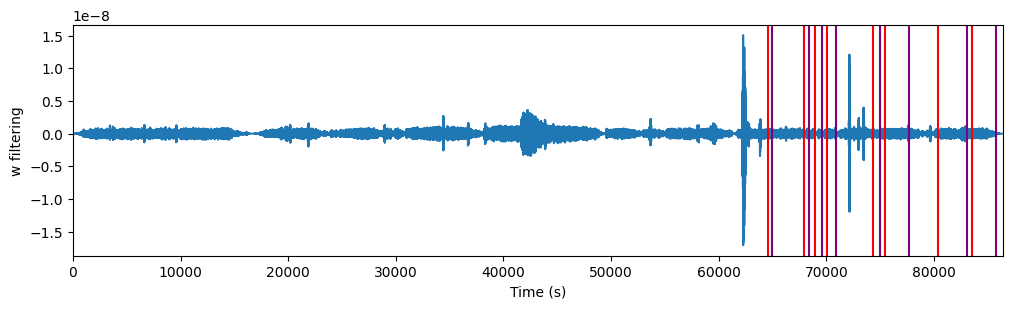

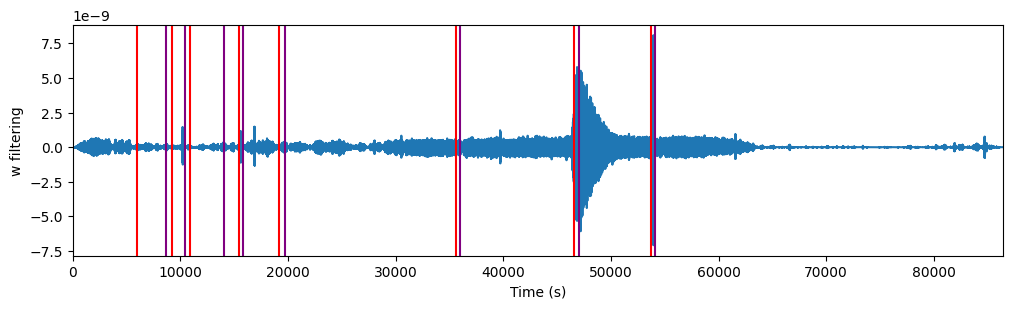

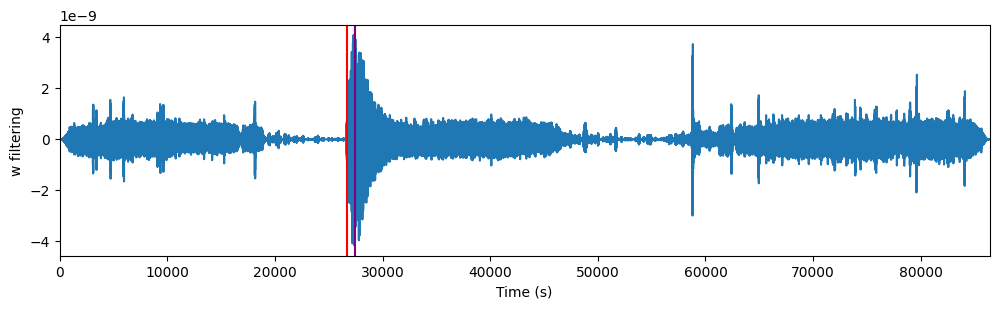

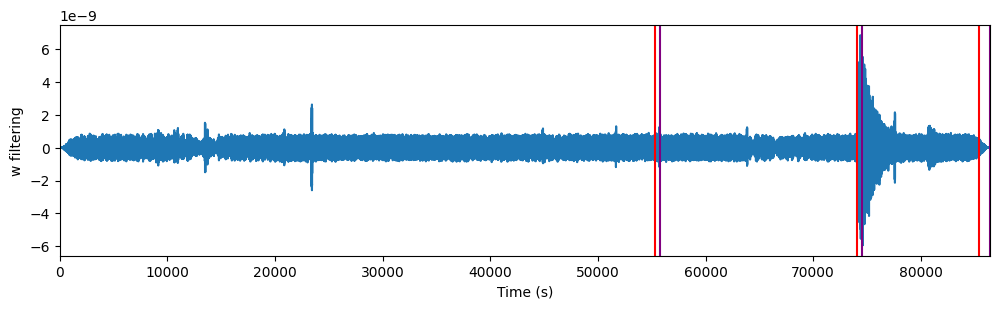

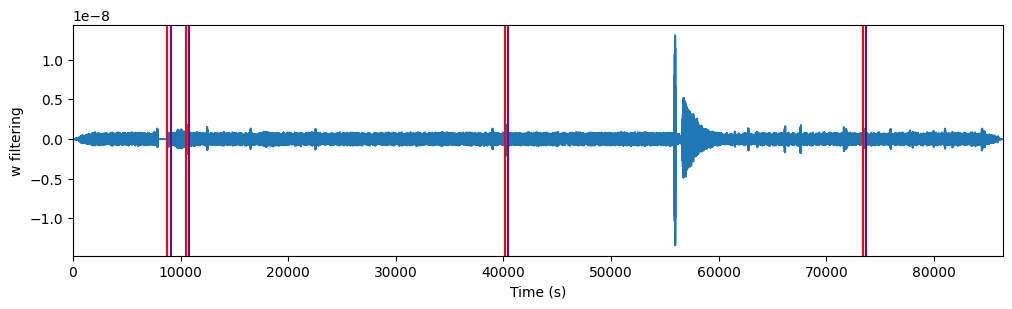

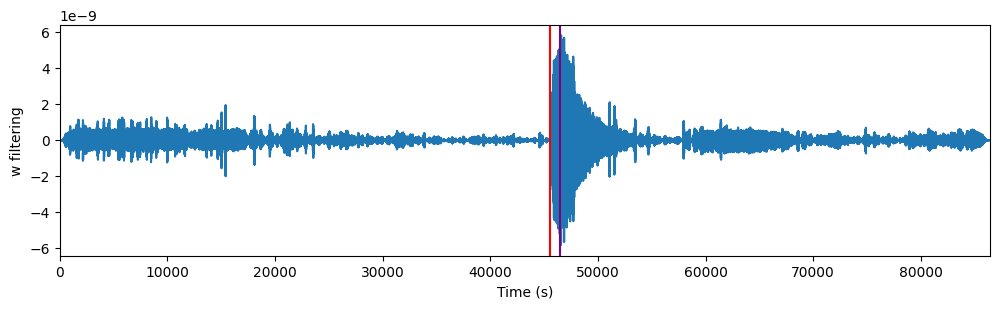

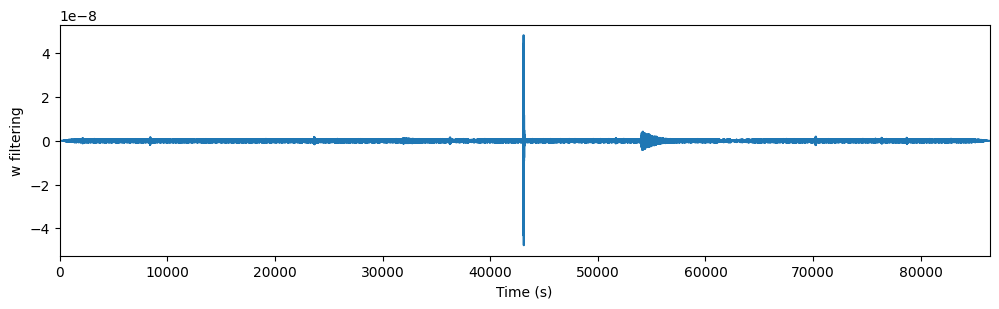

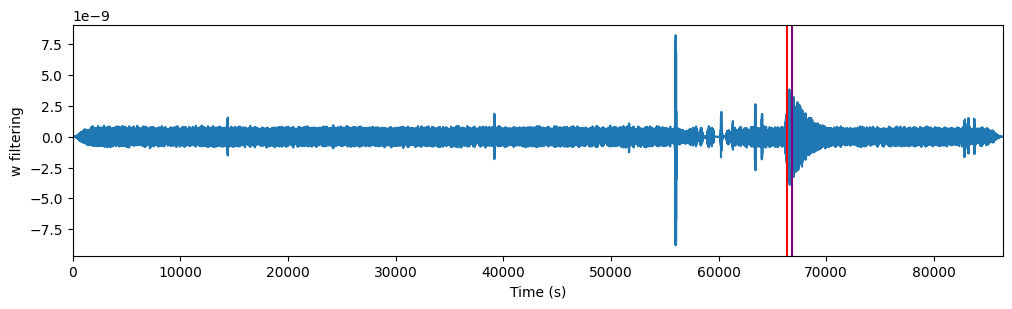

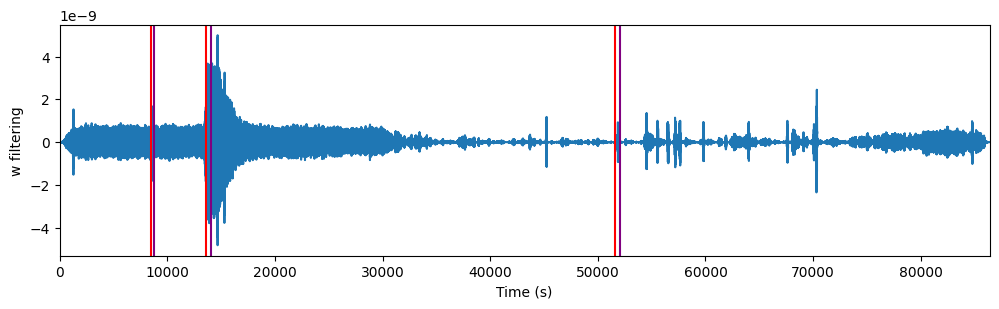

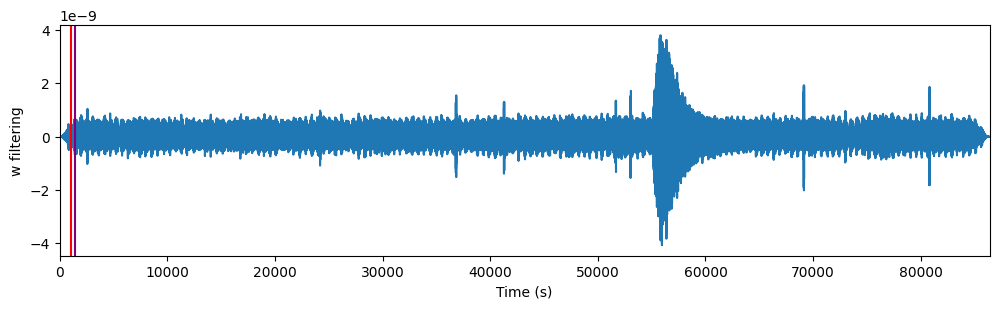

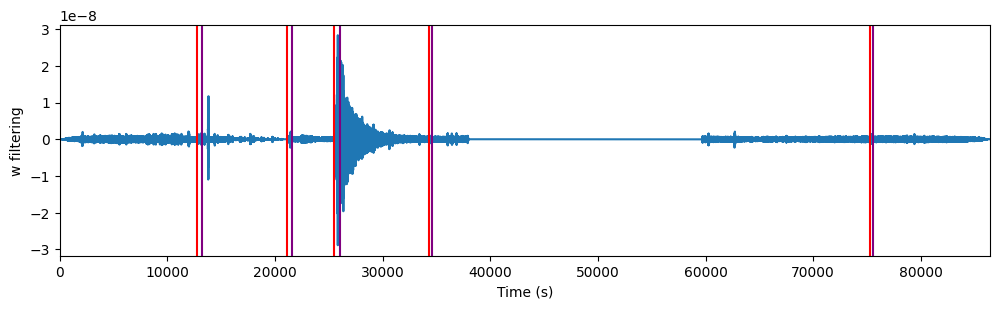

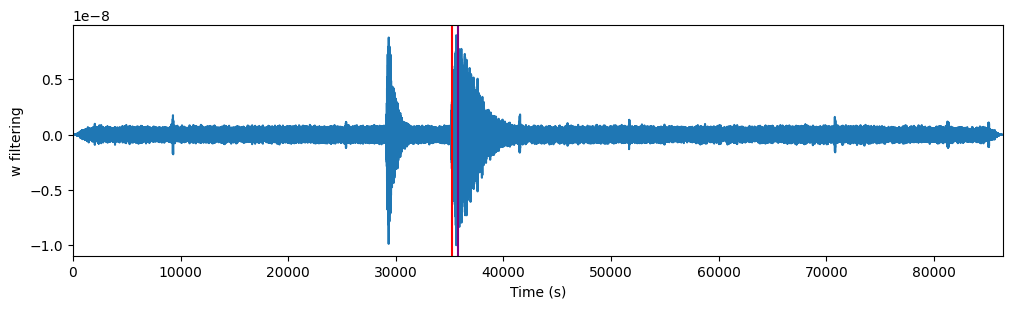

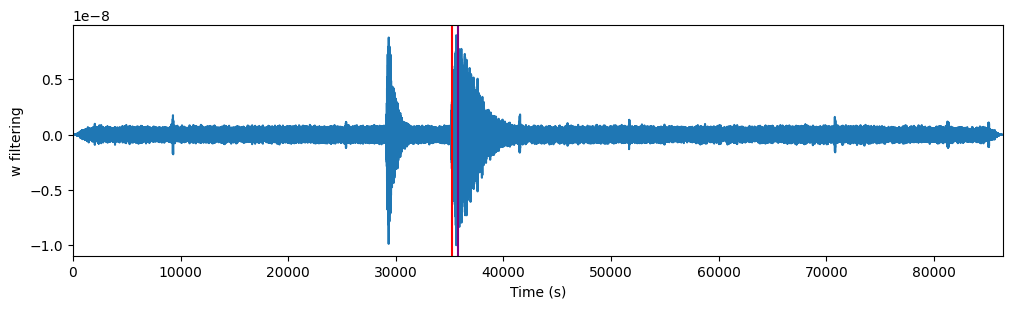

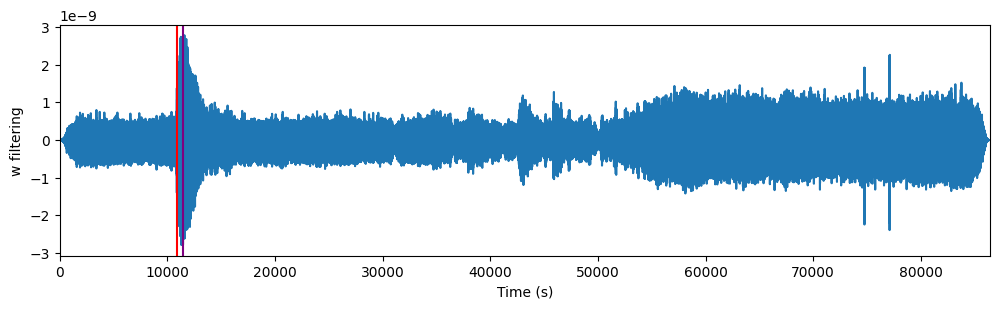

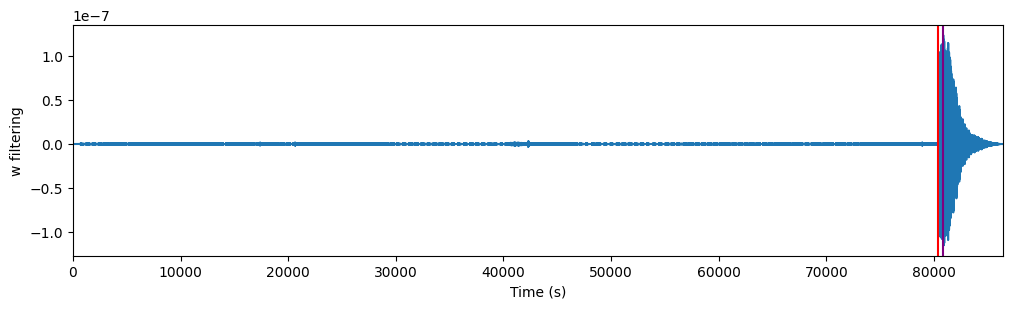

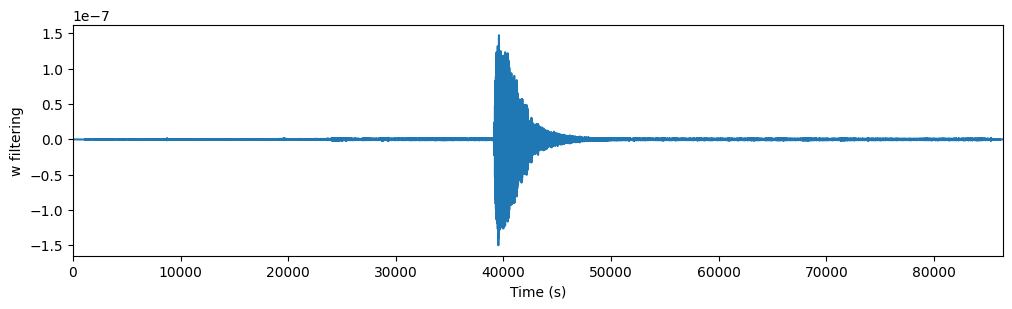

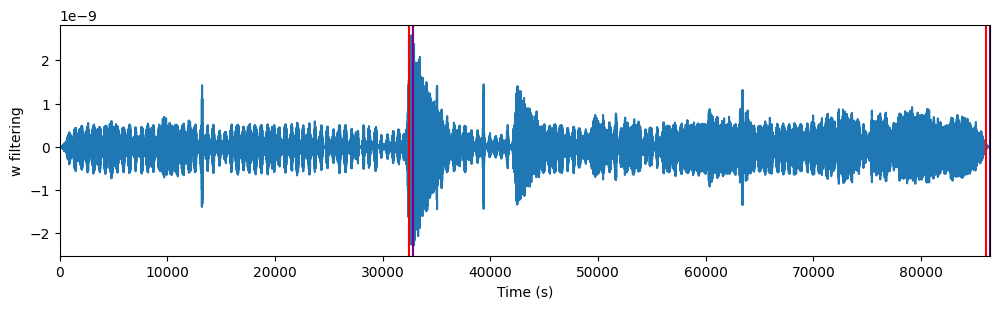

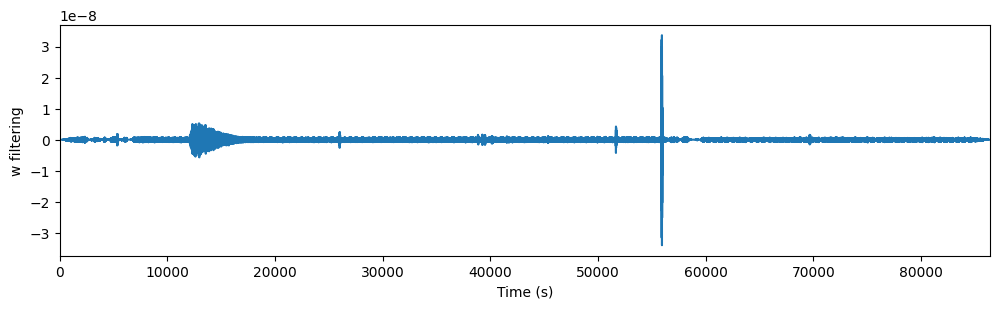

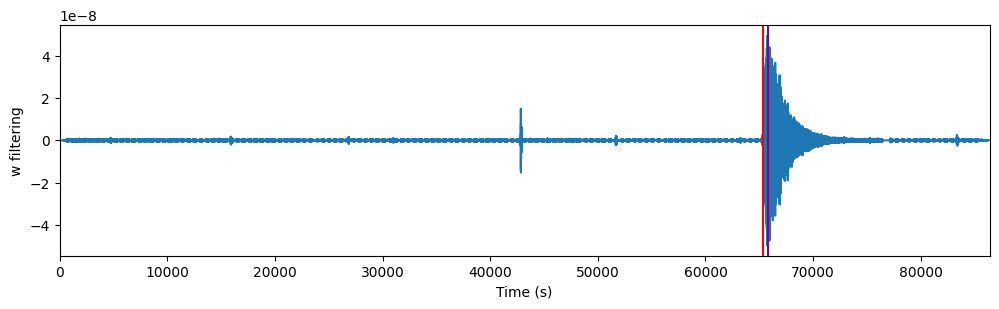

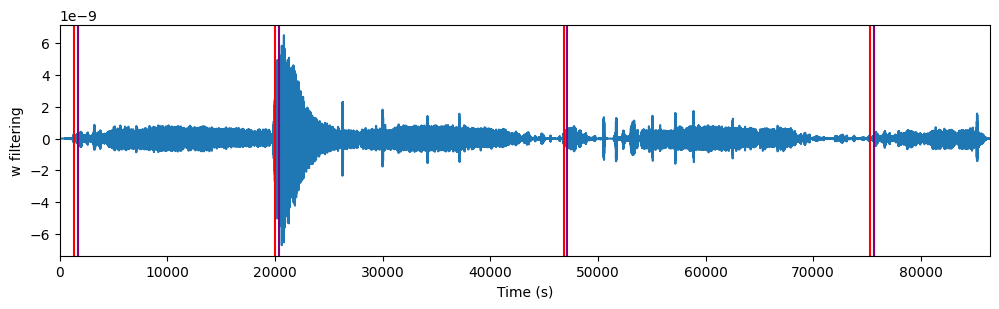

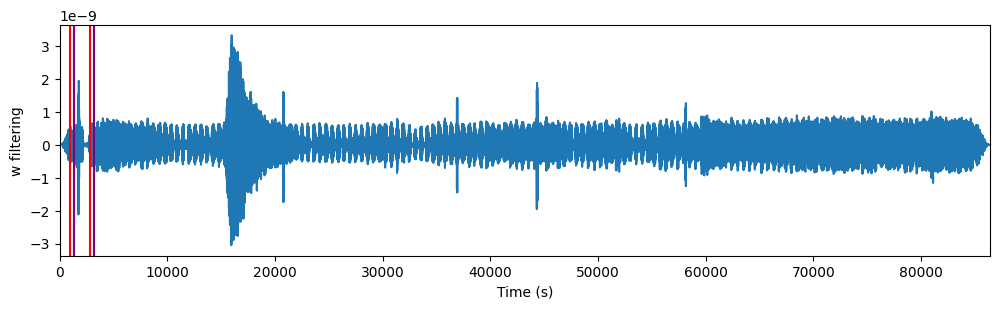

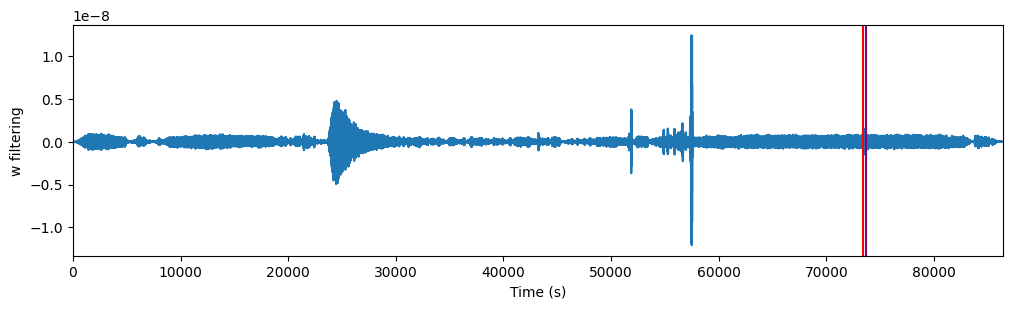

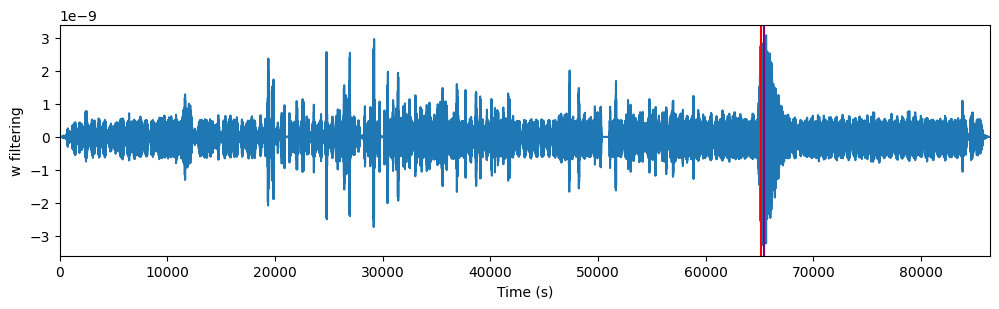

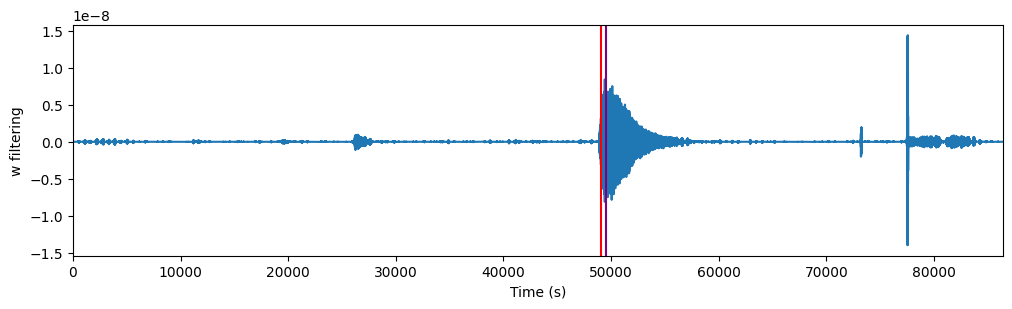

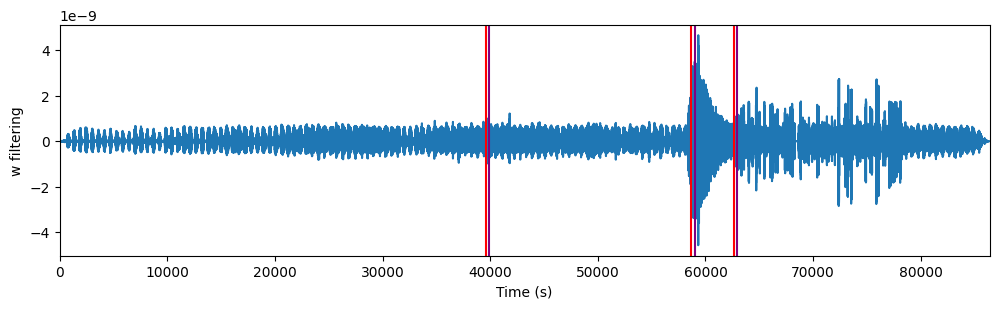

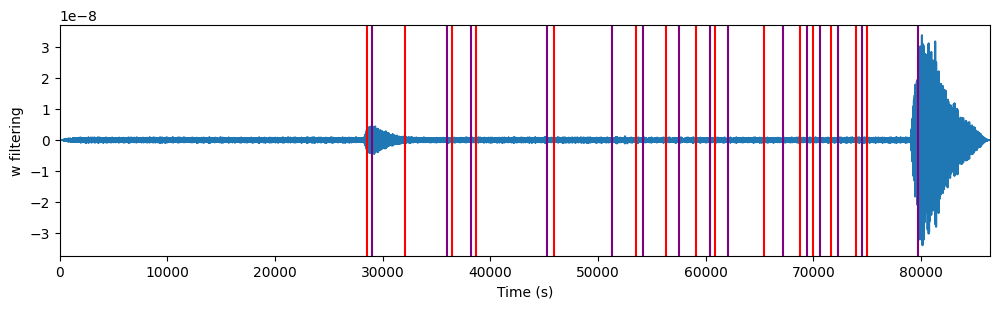

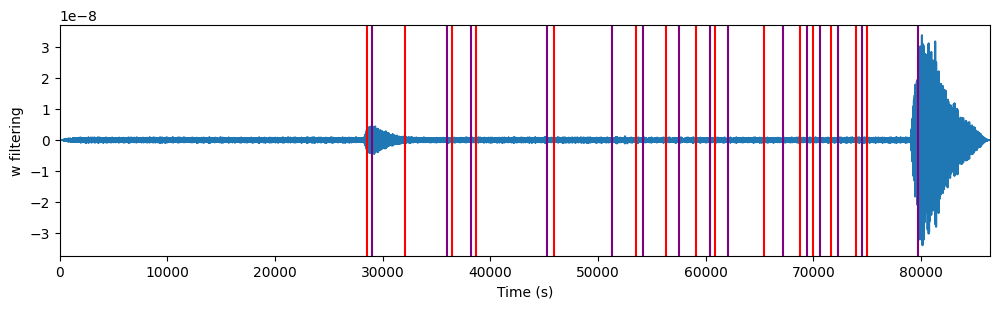

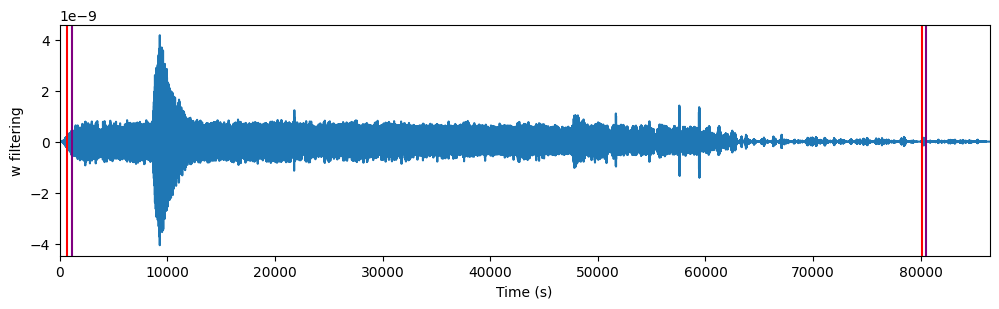

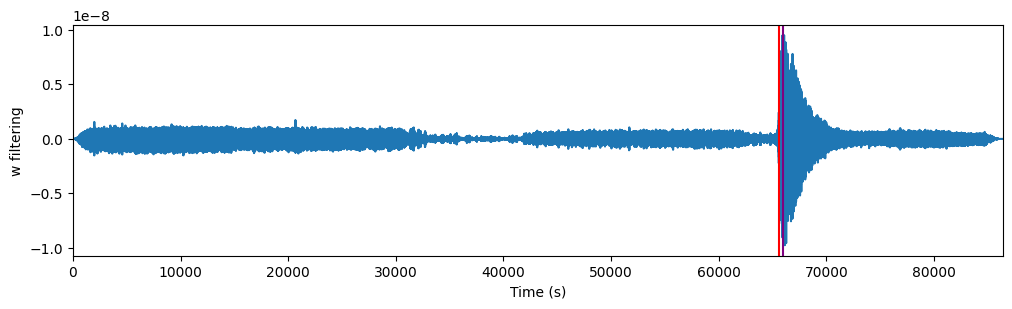

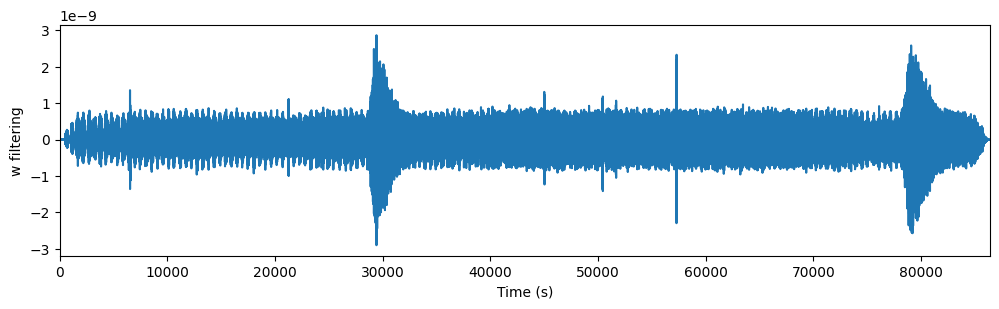

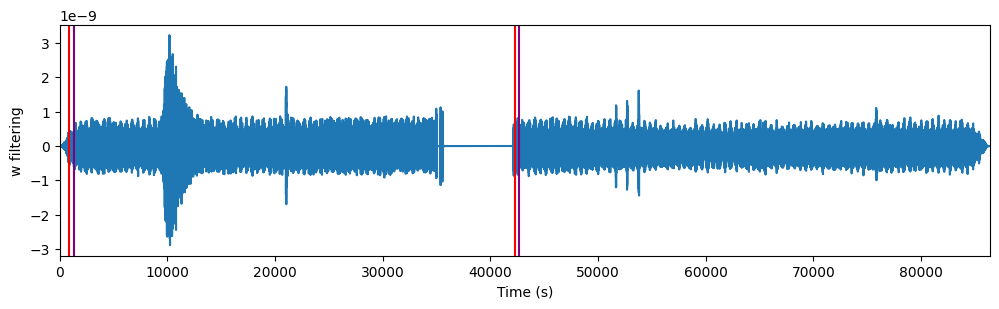

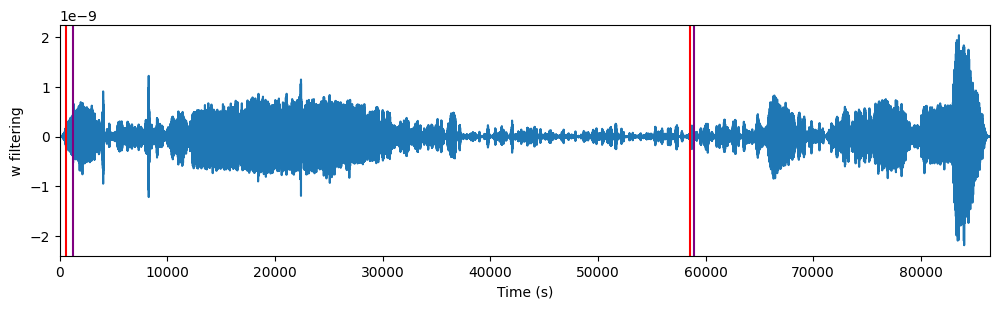

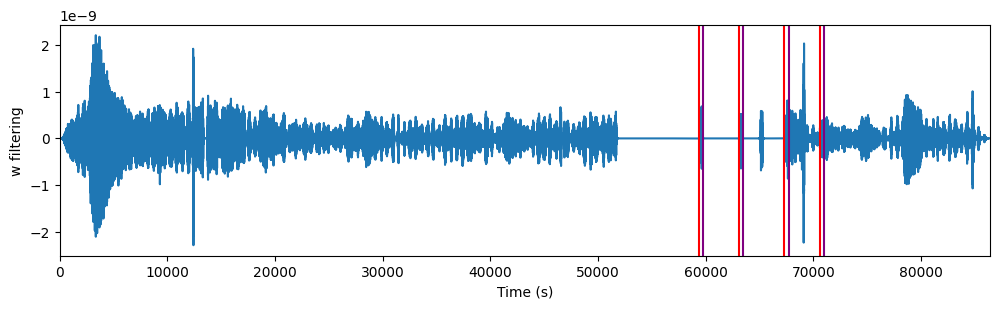

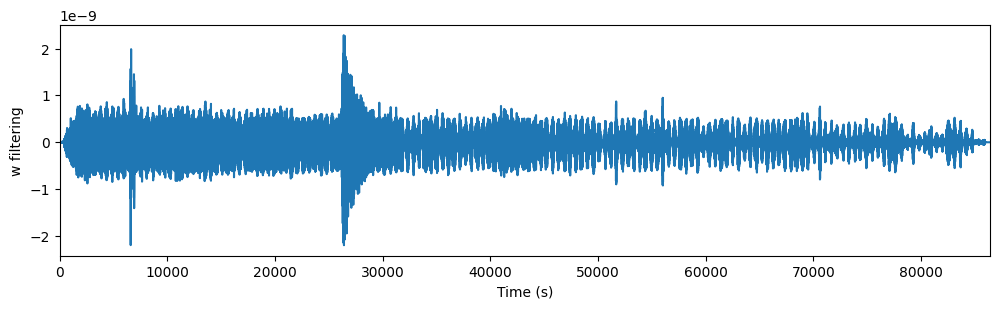

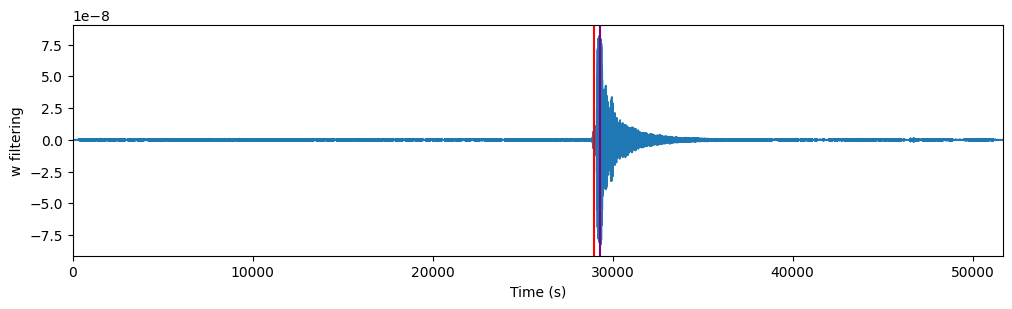

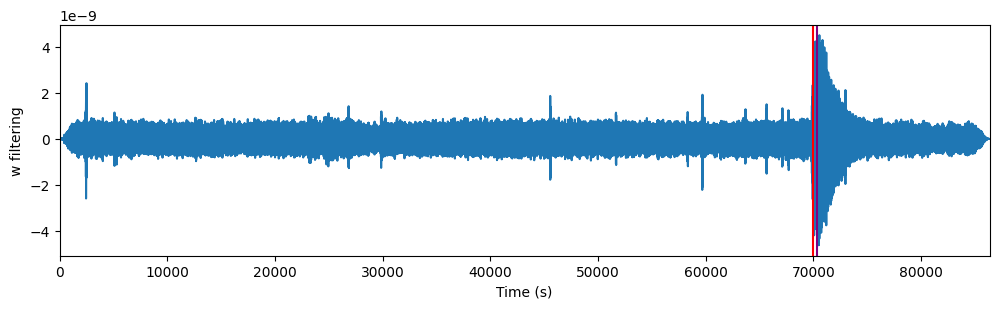

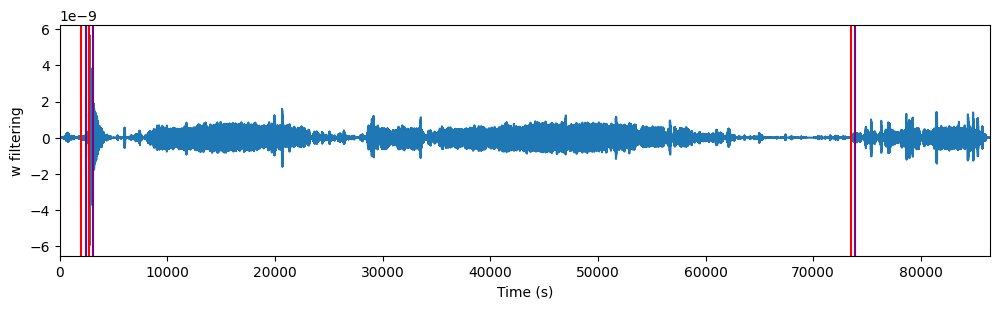

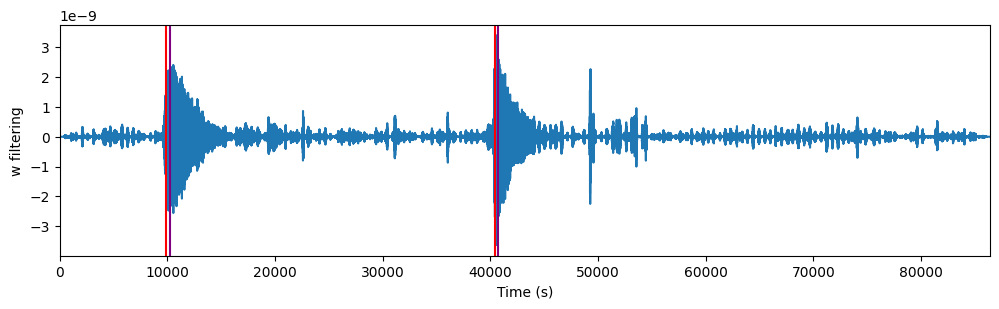

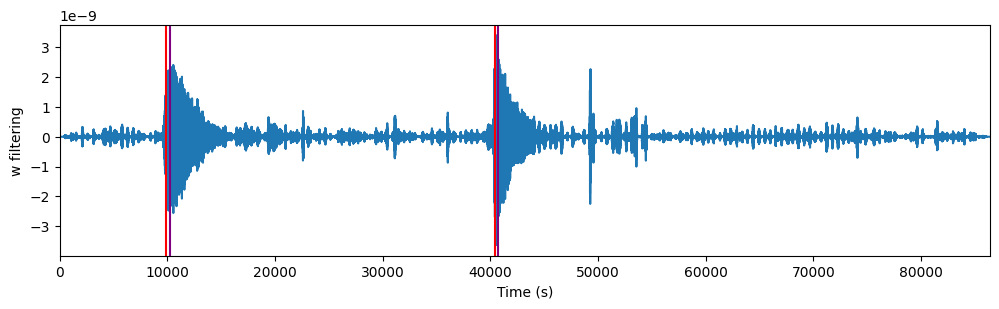

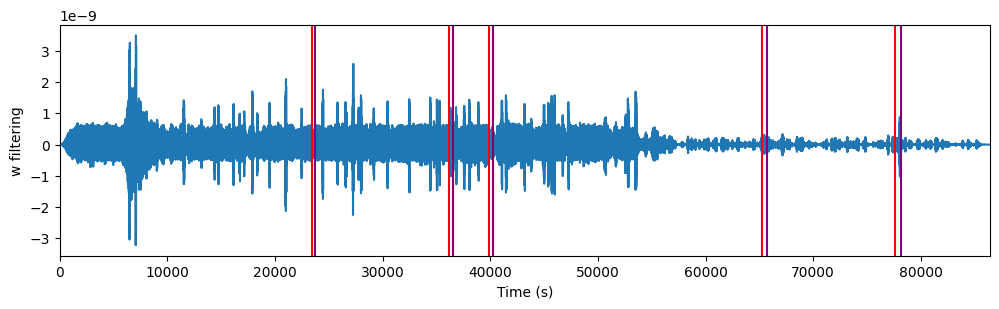

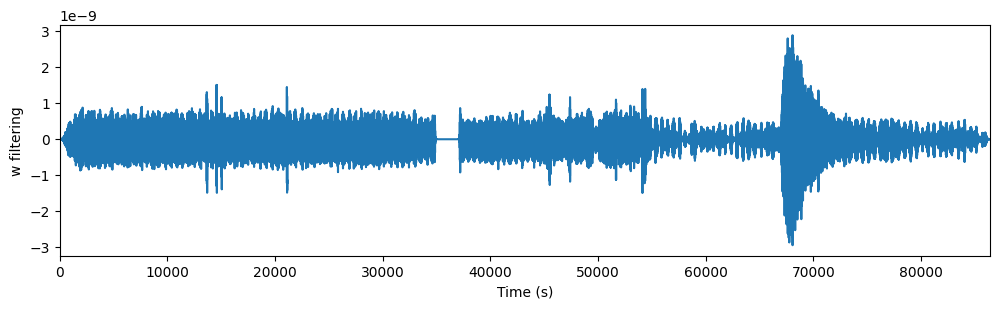

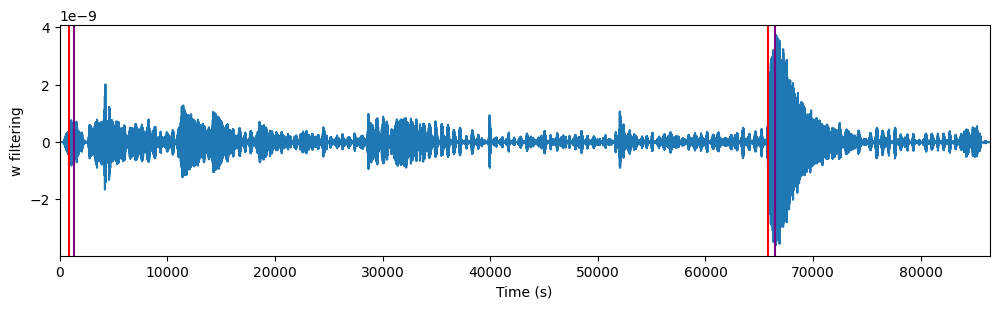

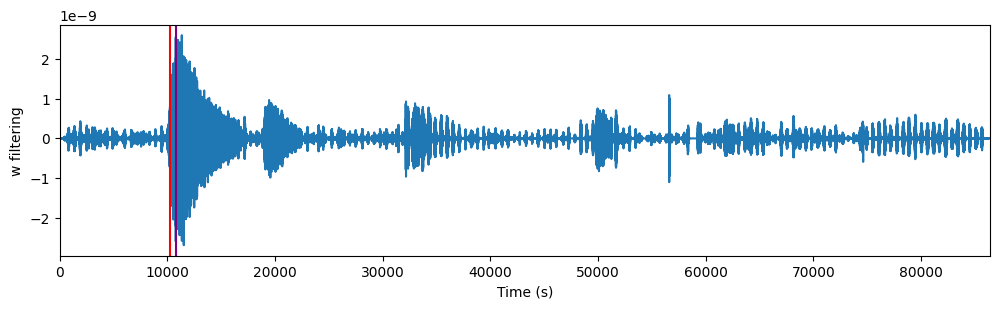

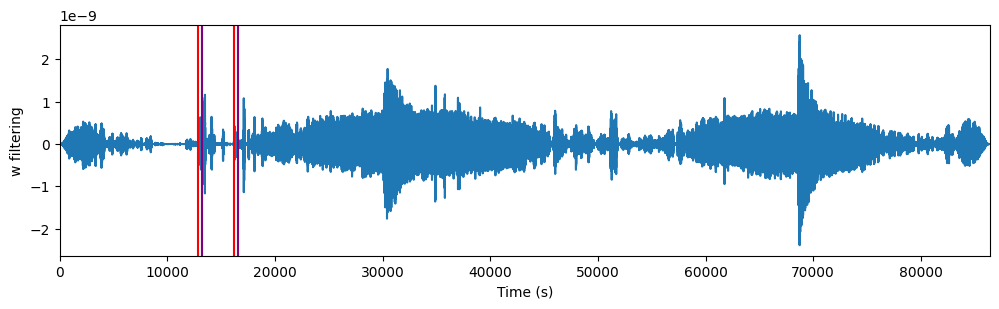

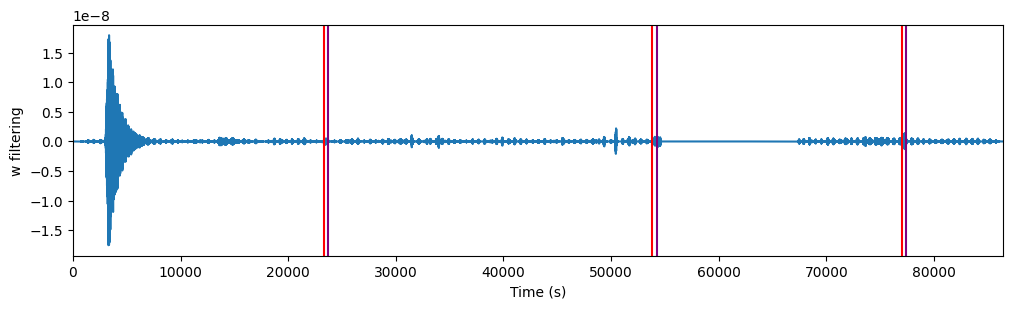

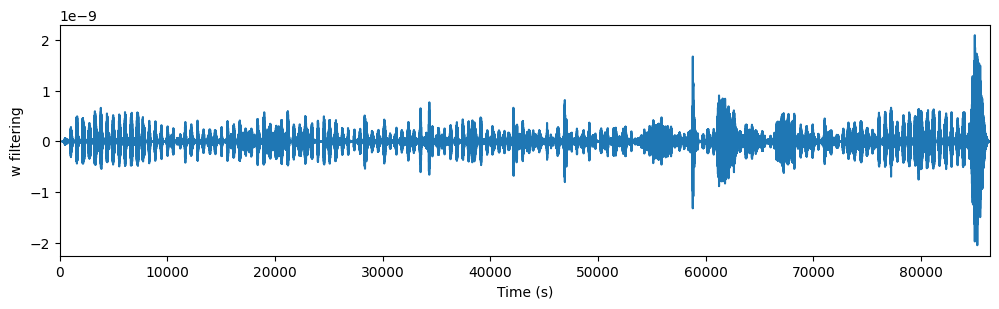

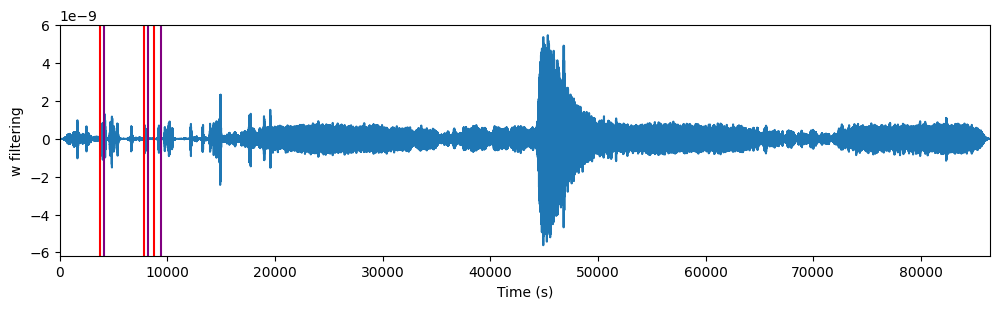

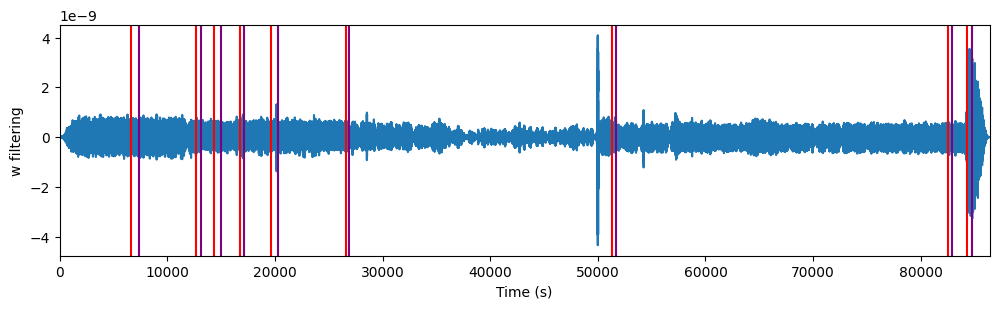

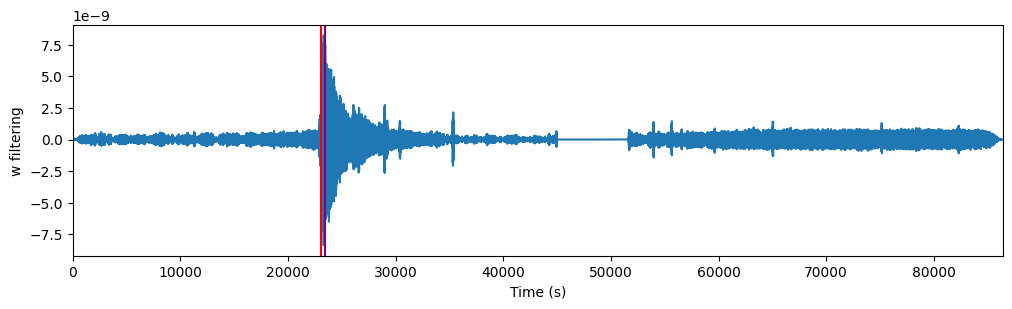

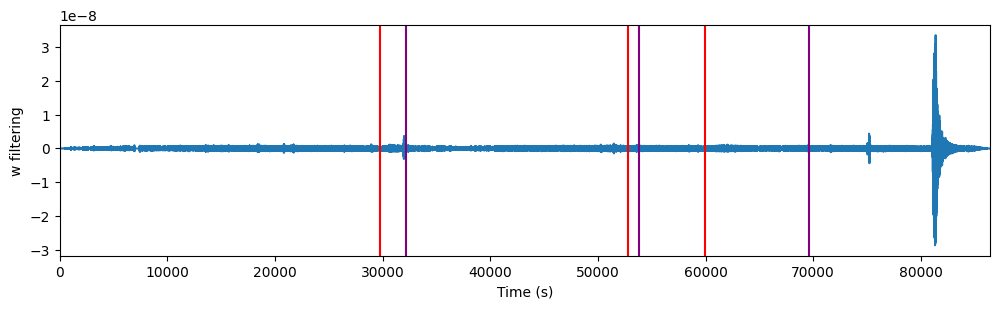

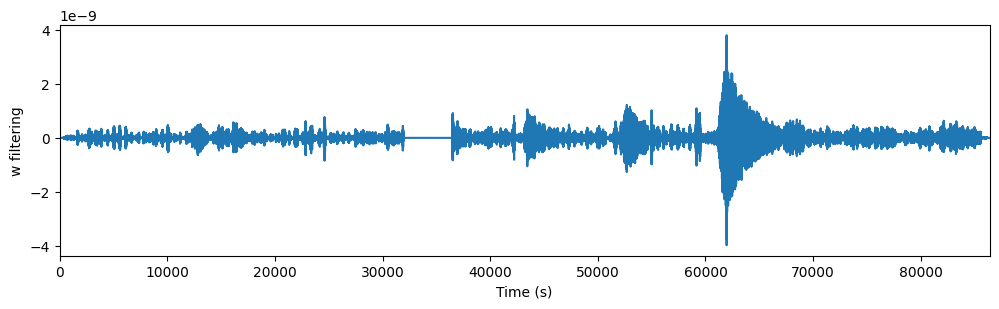

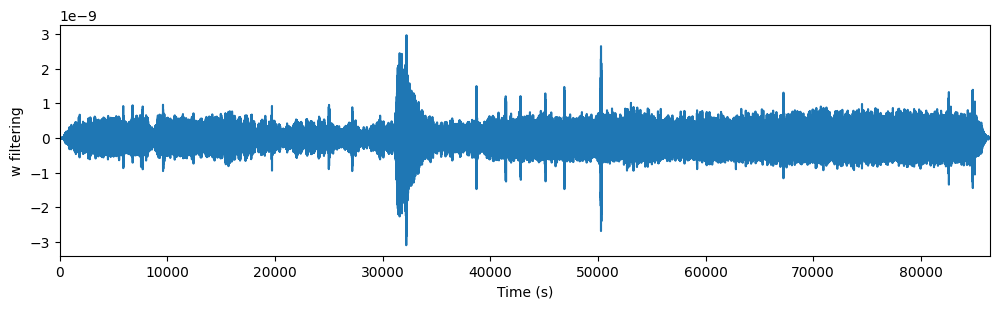

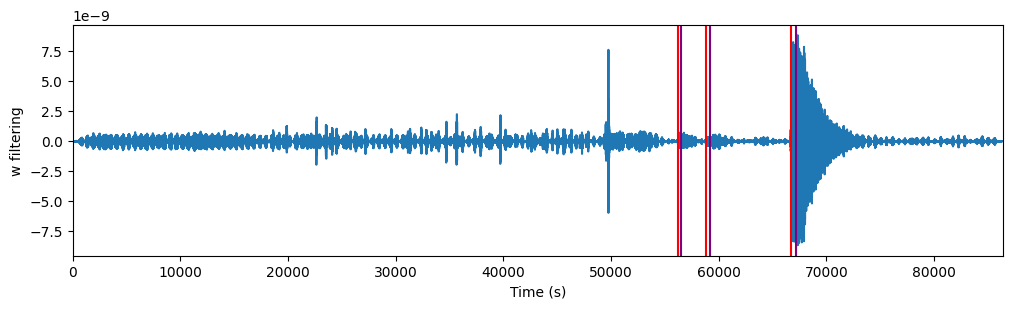

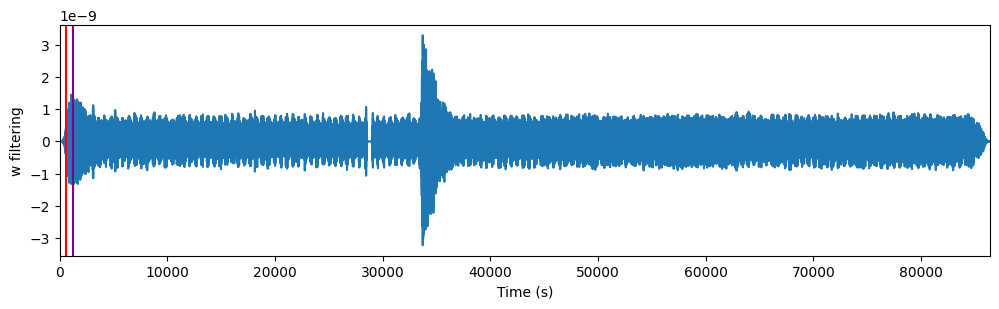

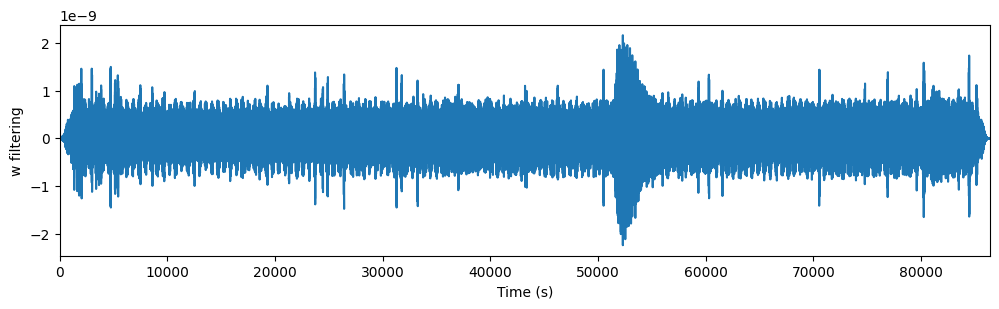

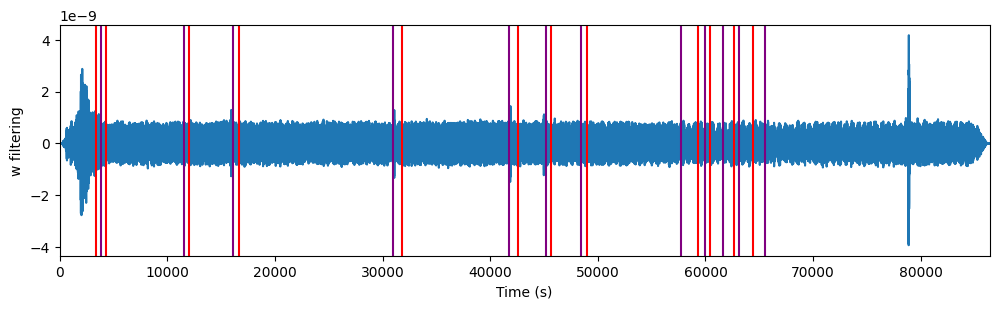

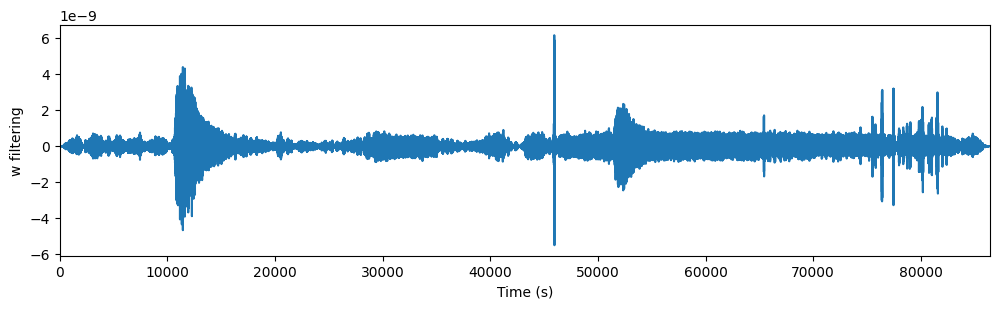

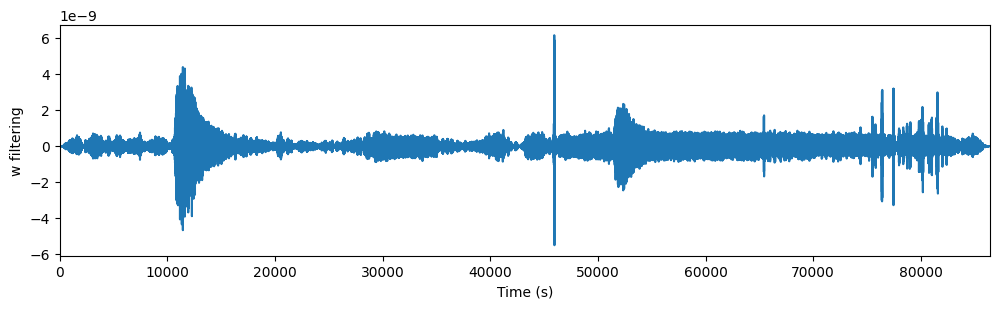

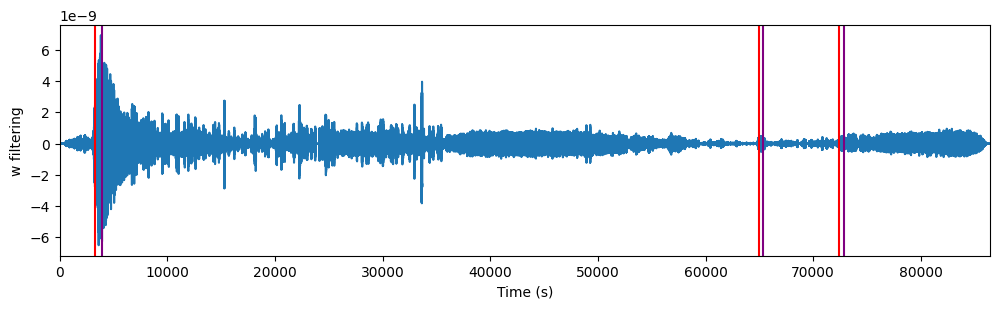

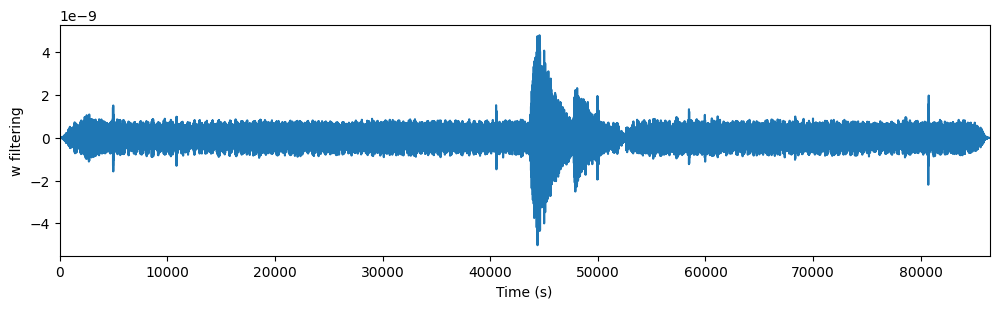

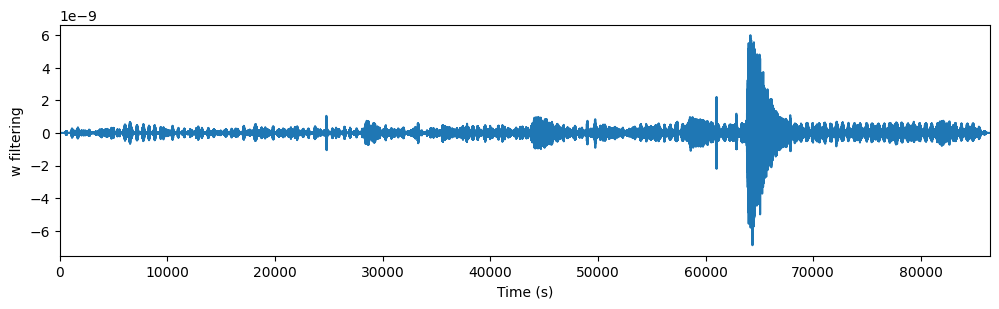

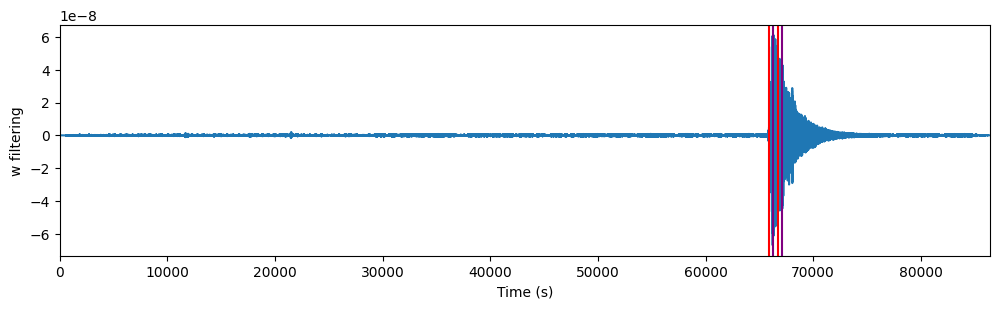

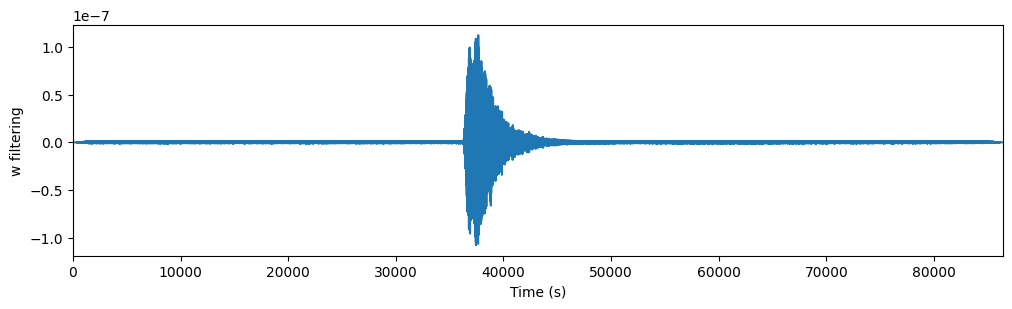

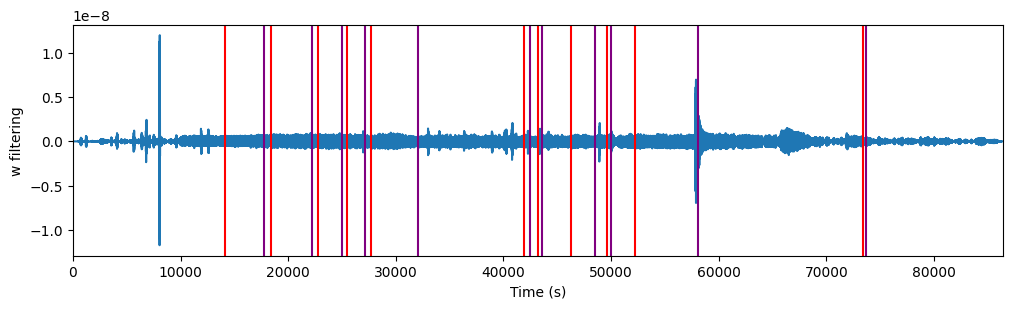

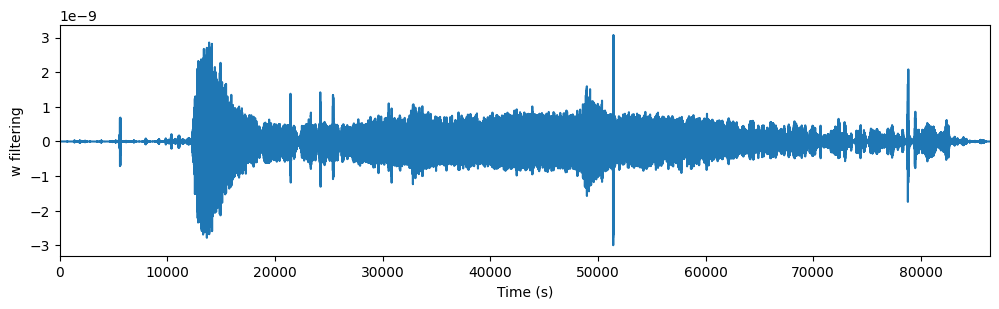

In [18]:
cat_directory = './drive/MyDrive/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
time_rels = cat['time_rel(sec)']
mini_seed_files = cat['filename']
mini_seed_files.head()
possible_starts = []

# iterate through each sample
for i in range(len(mini_seed_files)):
  # lol why is one of them not a valid file name
  if (mini_seed_files[i] == "xa.s12.00.mhz.1971-04-13HR00_evid00029"):
    print("here")
    continue

  # convert mini seed file to trace
  tr = mini_to_times_data(mini_seed_files[i])

  # use high pass filter to filter traces
  # tr_filt = high_pass_filter(tr.data, 1.5, tr.stats.sampling_rate)
  tr_filt = apply_lognormal_wavelet(tr.data)

  # use sta/lta alg'm to create sta/lta ratio graph
  cft = sta_lta(tr_filt, 120, 600, tr.stats.sampling_rate)

  # use throttle values to identify possible start times
  thr_on = 4.5
  thr_off = 1.5
  on_off = np.array(trigger_onset(cft, thr_on, thr_off))

  # add possible start times to data structure
  for j in range(len(on_off)):
    # add possible start time and sample that it is from
    if (on_off[j][1] - on_off[j][0] > 2000):
      # Filter based on width of on to off segment
      possible_starts.append((i, on_off[j][0]))

  # Plot the marked start and stop points
  fig,ax = plt.subplots(1,1,figsize=(12,3))
  ax.plot(tr.times(),tr.data)
  ax.set_xlim([min(tr.times()),max(tr.times())])
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('w filtering')
  for k in range(len(on_off)):
    if (on_off[k][1] - on_off[k][0] > 2000):
      triggers = on_off[k]
      ax.axvline(x = tr.times()[triggers[0]], color='red', label='Trig. On')
      ax.axvline(x = tr.times()[triggers[1]], color='purple', label='Trig. Off')

starts_and_labels = []
count = 0

# Get the correct labels of the training data
cat_directory = './drive/MyDrive/data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)
rel_arrival_times = []
for i in range(len(cat)):
  rel_arrival_times.append(cat.iloc[i]['time_rel(sec)'])

# Initialize array to see if we find the correct seismic event
rel_arrival_found = [0 for i in range(len(rel_arrival_times))]

# Filter possible starts based on proximity to the true value
for i in range(len(possible_starts)):
  # Iterate the count if we are close enough to the true value
  if (abs(rel_arrival_times[possible_starts[i][0]] - possible_starts[i][1]) <= 2500):
    count += 1
    starts_and_labels.append((possible_starts[i][0],possible_starts[i][1], 1))
    rel_arrival_found[possible_starts[i][0]] = 1
  else:
    starts_and_labels.append((possible_starts[i][0],possible_starts[i][1], 0))

print("COUNT IS", count)
print("ACCURACY IS", sum(rel_arrival_found) / len(rel_arrival_found))
print("PPV IS", count / len(possible_starts))

starts_and_labels

# Calculate Metrics of Seismic Detection Algorithm